In [2]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import hvplot.pandas
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
from fuzzywuzzy import process
import requests

In [5]:
#load model for results
model = load('project2_random_forest_model.joblib')

In [7]:
company_request = 'columbia'

In [8]:
def getCompany(text):
    r = requests.get('https://api.iextrading.com/1.0/ref-data/symbols')
    stockList = r.json()
    return process.extractOne(text, stockList)[0]

In [9]:
company = getCompany(company_request)

In [10]:
symbol = company['symbol']
company_name = company['name']
print(symbol)
print(company_name)

CLBK
COLUMBIA FINANCIAL INC


In [11]:
data = yf.download(symbol, parse_dates=True, infer_datetime_format=True)

[*********************100%***********************]  1 of 1 downloaded


In [12]:
data['Daily Return'] = data['Close'].dropna().pct_change()

In [13]:
# Set short and long windows
short_window = 50
long_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

short_vol_window = 5
long_vol_window = 21

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

# Set the short window and long windows
rolling_short_window = 50
rolling_long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
data["SMA50"] = data["Close"].rolling(window=short_window).mean()
data["SMA100"] = data["Close"].rolling(window=long_window).mean()

# Initialize the new `Signal` column
data["SMA_Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
data["SMA_Signal"][short_window:] = np.where(
    data["SMA50"][short_window:] < data["SMA100"][short_window:], 1.0, 0.0
)

data

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-20,15.31,15.75,15.30,15.42,15.42,6816963,NaN,15.420000,15.420000,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2018-04-23,15.40,15.50,15.35,15.45,15.45,1608100,0.001946,15.435104,15.435052,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2018-04-24,15.43,15.83,15.40,15.73,15.73,1057500,0.018123,15.534768,15.534050,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2018-04-25,15.50,15.70,15.50,15.56,15.56,566400,-0.010807,15.541208,15.540605,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2018-04-26,15.68,15.73,15.50,15.72,15.72,789200,0.010283,15.577965,15.576983,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


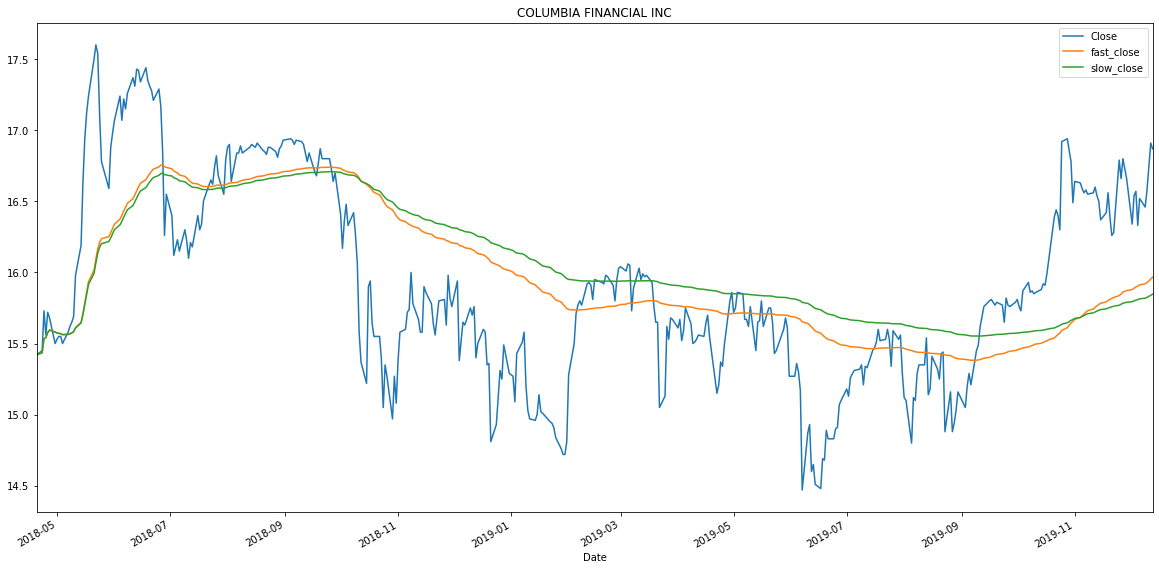

In [14]:
data[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10), title=company_name)

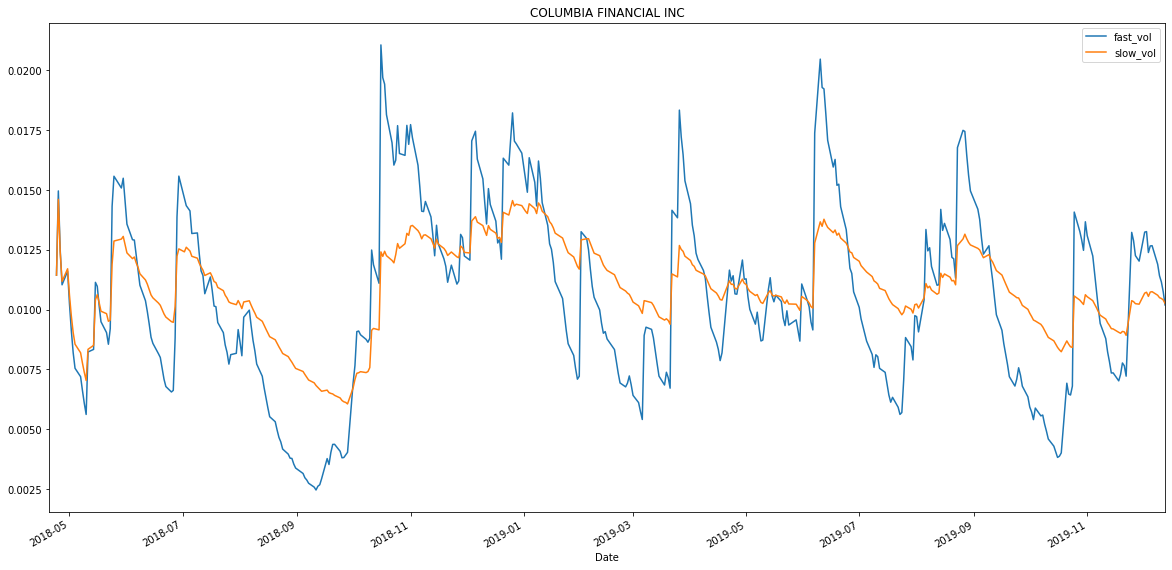

In [15]:
data[['fast_vol', 'slow_vol']].plot(figsize=(20,10), title=company_name)

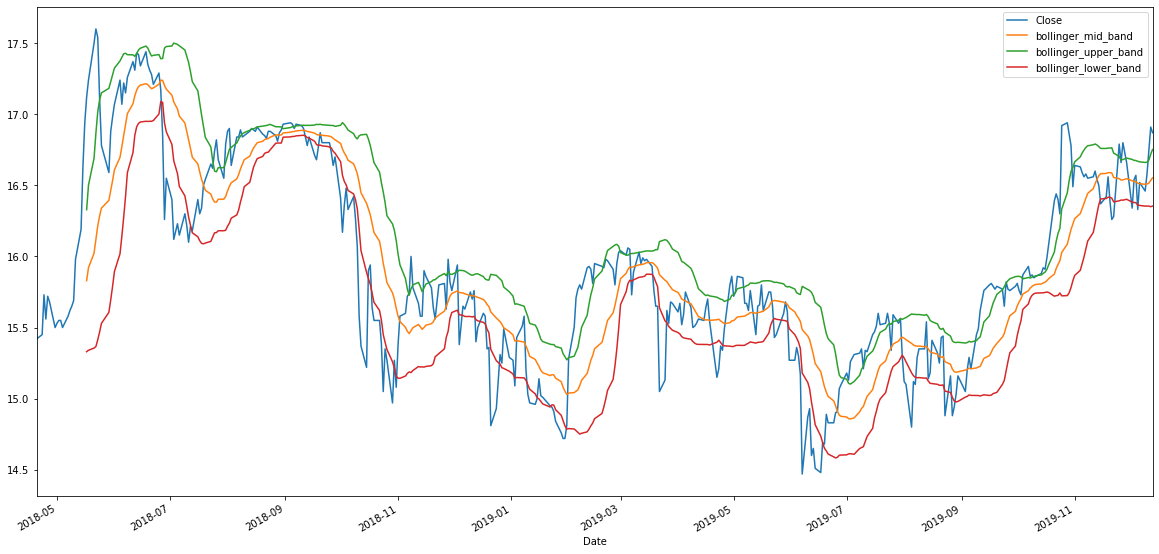

In [16]:
# Plot the Bollinger Bands for BTC/USD closing prices
data[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [17]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'SMA_Signal']

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-09,1.0,-1.0,0.0,0.0
2019-12-10,1.0,-1.0,0.0,0.0
2019-12-11,1.0,-1.0,-1.0,0.0
2019-12-12,1.0,-1.0,-1.0,0.0
2019-12-13,1.0,1.0,-1.0,0.0


In [18]:
data[x_var_list] = data[x_var_list].shift(1)
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-09,1.0,-1.0,0.0,0.0
2019-12-10,1.0,-1.0,0.0,0.0
2019-12-11,1.0,-1.0,0.0,0.0
2019-12-12,1.0,-1.0,-1.0,0.0
2019-12-13,1.0,-1.0,-1.0,0.0


In [19]:
#signal_dataand replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-23,15.40,15.50,15.35,15.45,15.45,1608100,0.001946,15.435104,15.435052,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2018-04-24,15.43,15.83,15.40,15.73,15.73,1057500,0.018123,15.534768,15.534050,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2018-04-25,15.50,15.70,15.50,15.56,15.56,566400,-0.010807,15.541208,15.540605,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2018-04-26,15.68,15.73,15.50,15.72,15.72,789200,0.010283,15.577965,15.576983,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2018-04-27,15.75,15.75,15.60,15.68,15.68,515100,-0.002545,15.595565,15.594452,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


In [20]:
data['Positive Return'] = np.where(data['Daily Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-23,15.40,15.50,15.35,15.45,15.45,1608100,0.001946,15.435104,15.435052,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2018-04-24,15.43,15.83,15.40,15.73,15.73,1057500,0.018123,15.534768,15.534050,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2018-04-25,15.50,15.70,15.50,15.56,15.56,566400,-0.010807,15.541208,15.540605,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2018-04-26,15.68,15.73,15.50,15.72,15.72,789200,0.010283,15.577965,15.576983,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2018-04-27,15.75,15.75,15.60,15.68,15.68,515100,-0.002545,15.595565,15.594452,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,16.44,16.55,16.35,16.46,16.46,131200,-0.003632,15.919731,15.819039,1.0,...,0.153447,16.660947,16.354053,0.0,0.0,0.0,16.3468,15.8731,0.0,0.0
2019-12-10,16.48,16.59,16.42,16.58,16.58,131700,0.007290,15.928850,15.824612,1.0,...,0.153872,16.662372,16.354628,0.0,0.0,0.0,16.3626,15.8837,0.0,1.0
2019-12-11,16.54,16.78,16.51,16.75,16.75,137900,0.010253,15.940191,15.831385,1.0,...,0.162007,16.678007,16.353993,0.0,-1.0,0.0,16.3814,15.8959,0.0,1.0


In [21]:
# Construct training start and end dates
start = data.index.min().strftime(format= '%Y-%m-%d')
end = data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Start: {start}")
print(f": {end}")

Start: 2018-04-23
: 2019-12-13


In [25]:
# Construct the datasets
x_data = data[x_var_list][start:end]

# Predictions

In [26]:
predictions = model.predict(x_data)
predictions

array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 1.

In [27]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
data["Predicted Value"] = predictions
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return,Predicted Value
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-23,15.40,15.50,15.35,15.45,15.45,1608100,0.001946,15.435104,15.435052,1.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0
2018-04-24,15.43,15.83,15.40,15.73,15.73,1057500,0.018123,15.534768,15.534050,1.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0
2018-04-25,15.50,15.70,15.50,15.56,15.56,566400,-0.010807,15.541208,15.540605,1.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2018-04-26,15.68,15.73,15.50,15.72,15.72,789200,0.010283,15.577965,15.576983,1.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0,1.0
2018-04-27,15.75,15.75,15.60,15.68,15.68,515100,-0.002545,15.595565,15.594452,1.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,16.44,16.55,16.35,16.46,16.46,131200,-0.003632,15.919731,15.819039,1.0,...,16.660947,16.354053,0.0,0.0,0.0,16.3468,15.8731,0.0,0.0,1.0
2019-12-10,16.48,16.59,16.42,16.58,16.58,131700,0.007290,15.928850,15.824612,1.0,...,16.662372,16.354628,0.0,0.0,0.0,16.3626,15.8837,0.0,1.0,1.0
2019-12-11,16.54,16.78,16.51,16.75,16.75,137900,0.010253,15.940191,15.831385,1.0,...,16.678007,16.353993,0.0,-1.0,0.0,16.3814,15.8959,0.0,1.0,1.0


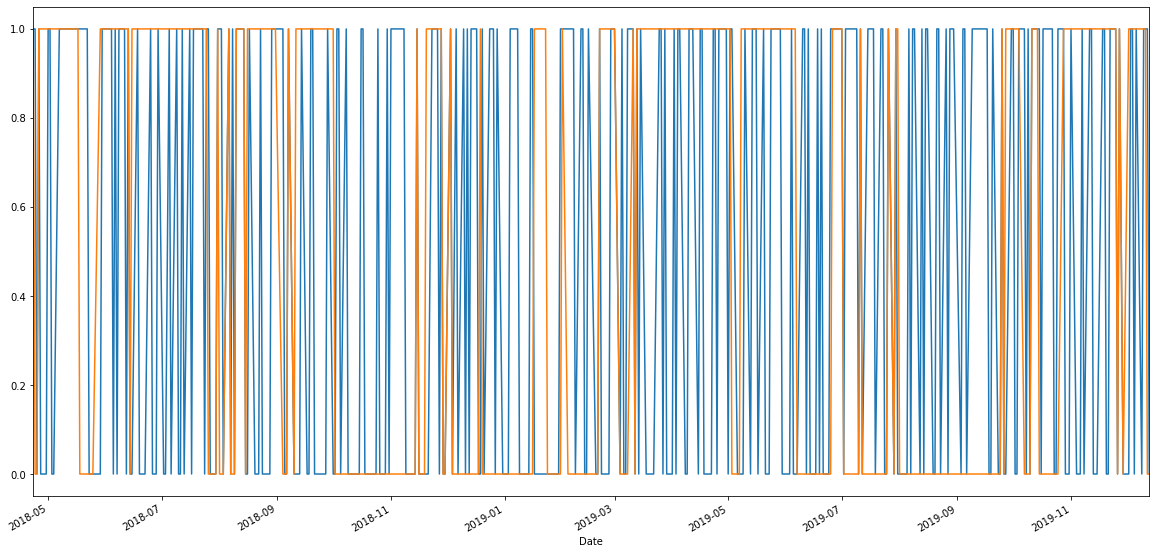

In [29]:
data['Positive Return'][start:end].plot(figsize=(20,10))
data['Predicted Value'][start:end].plot(figsize=(20,10))

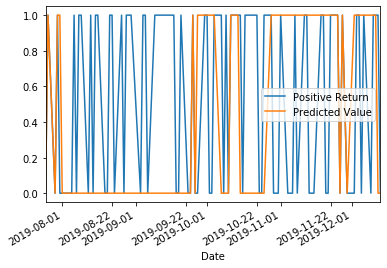

In [30]:
data[['Positive Return', 'Predicted Value']].tail(100).plot()

In [32]:
# Calculate the points in time at which a position should be taken, 1 or -1
data["Entry/Exit"] = data["Predicted Value"].diff()

In [33]:
#Visualize exit position relative to close price
exit = data[data['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = data[data['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = data[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = data[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [96]:
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return,Entry/Exit
Date,,,,,,,,,,,,,,,,,,,,,
1986-03-14,0.10,0.10,0.10,0.10,0.06,308160000,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1986-03-17,0.10,0.10,0.10,0.10,0.07,133171200,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1986-03-18,0.10,0.10,0.10,0.10,0.06,67766400,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1986-03-19,0.10,0.10,0.10,0.10,0.06,47894400,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1986-03-20,0.10,0.10,0.09,0.10,0.06,58435200,0.000000,0.100000,0.100000,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,151.07,152.21,150.91,151.36,151.36,16687400,-0.002570,137.585440,127.553183,1.0,...,151.511249,148.153751,0.0,0.0,-1.0,144.0992,140.8276,0.0,0.0,0.0
2019-12-10,151.29,151.89,150.76,151.13,151.13,16476100,-0.001520,137.771912,127.716040,1.0,...,151.536487,148.630513,0.0,0.0,0.0,144.3412,140.9727,0.0,0.0,0.0
2019-12-11,151.54,151.87,150.33,151.70,151.70,18856600,0.003772,137.963664,127.881709,1.0,...,151.624325,149.005675,0.0,-1.0,0.0,144.6338,141.1054,0.0,1.0,0.0
